#**Setting up the Model**
previously trained the model (see file titled "Final Version of ResNet2 for SP.ipynb") and now uploaded it here

note that one must upload the file called "ResNet2.pth" to the notebook as this is where the all the weights and biases are stored, see the [GitHub](https://github.com/rnayebi21/CNN-ResNet-Lung-Cancer-Predictions) for this file.

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torch.utils import data

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Mounted at /content/drive


In [2]:
# Data transforms (normalization & data augmentation)
stats = ((0.66972744, 0.53412294, 0.85122865), (0.1290, 0.1743, 0.0742))  # first element is mean of RGB vals, second element is the standard deviation of RBG vals
train_tfms = transforms.Compose([transforms.RandomCrop(588, padding=4, padding_mode='reflect'),  #change 32
                         transforms.RandomHorizontalFlip(), 
                         # transforms.RandomRotate
                         # transforms.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)]) # just a series of adjustments we want to do on the dataset
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

In [45]:
def denormalize(img):
  inv_normalize = transforms.Normalize(
    mean=[-0.66972744/0.1290, -0.53412294/0.1743, -0.85122865/0.0742],
    std=[1/0.1290, 1/0.1743, 1/0.0742]
  )
  inv_tensor = inv_normalize(img.clamp(0, 1))
  return inv_tensor.permute(1, 2, 0) #can directly use plt.imshow on this

In [3]:
train_ds = torchvision.datasets.ImageFolder(root="/content/drive/My Drive/12th Grade 2020 - 2021/Senior Project/Project/SeparatedData/train", transform=train_tfms)
valid_ds = torchvision.datasets.ImageFolder(root="/content/drive/My Drive/12th Grade 2020 - 2021/Senior Project/Project/SeparatedData/test", transform=valid_tfms)

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
device = get_default_device()
device

device(type='cuda')

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [7]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.max1 = nn.MaxPool2d((3,3))
        self.conv1 = conv_block(in_channels, 32)
        self.conv2 = conv_block(32, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True)
        self.conv4 = conv_block(128, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(256, num_classes))
    def forward(self, xb):
        out = self.max1(xb)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [8]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

In [9]:
state_dict = torch.load('ResNet2.pth')
model = to_device(ResNet9(3, 3), device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
total = 100
amt_right= 0
for i in range(total):
  img, label = valid_ds[i]
  if train_ds.classes[label] == predict_image(img, model):
     amt_right+=1

print(amt_right/total)

0.92


In [54]:
print(model.state_dict())

OrderedDict([('conv1.0.weight', tensor([[[[ 0.0396, -0.1429, -0.1137],
          [ 0.0365, -0.1312,  0.0905],
          [-0.1927, -0.1224,  0.1243]],

         [[-0.0581,  0.0224,  0.1710],
          [ 0.1168, -0.0925,  0.1431],
          [-0.1750, -0.0848,  0.1357]],

         [[-0.1511,  0.0954, -0.1261],
          [ 0.1494, -0.0805,  0.1359],
          [-0.1300, -0.1199, -0.1833]]],


        [[[ 0.1910, -0.1198,  0.1885],
          [ 0.1544,  0.1816, -0.0598],
          [ 0.1181,  0.1857,  0.1022]],

         [[ 0.1079,  0.1080,  0.1666],
          [ 0.0139, -0.1603, -0.1715],
          [-0.1610,  0.0519,  0.0242]],

         [[ 0.0369,  0.0149,  0.1683],
          [-0.0817,  0.0684, -0.1413],
          [-0.0814,  0.0031, -0.1884]]],


        [[[ 0.0378,  0.1070, -0.0928],
          [-0.1373,  0.0471,  0.1809],
          [-0.1879,  0.0479, -0.0618]],

         [[-0.1814, -0.0707,  0.1605],
          [ 0.1880, -0.1457, -0.1038],
          [-0.0027,  0.1466, -0.1582]],

         [[-

#**Individual Predictions**
(total of 3000 test images to choose from)

Label: lung_aca , Predicted: lung_aca


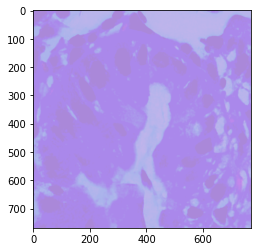

In [47]:
img, label = valid_ds[0]
# plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.imshow(denormalize(img))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: lung_n , Predicted: lung_n


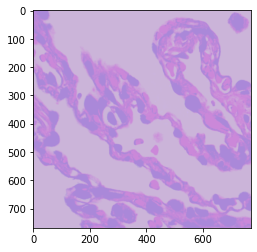

In [49]:
img, label = valid_ds[1002]
# plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.imshow(denormalize(img))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: lung_scc , Predicted: lung_scc


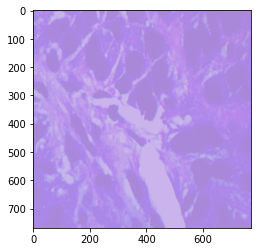

In [50]:
img, label = valid_ds[2002]
# plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.imshow(denormalize(img))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))